In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from utils.helpers import *
from utils.plotting import *
from utils.glm_models import *

# Import relevant SBL modules
import sbl_agents.sbl_cat_dir as sbl_cd
import sbl_agents.sbl_hmm as sbl_hmm

# Set random seed for replicability and define directories
np.random.seed(seed=1234)
results_dir = os.getcwd() + "/results/"
fig_dir = os.getcwd() + "/figures/"
data_dir = os.getcwd() + "/data/"

In [2]:
# General Model Settings
model_types = ["SP", "AP", "TP"]
save_results = True
verbose = True

sample_files = [["sub-01/sub-01_ses-1_run-1", "sub-01/sub-01_ses-1_run-2",
                 "sub-01/sub-01_ses-1_run-3", "sub-01/sub-01_ses-1_run-4",
                 "sub-01/sub-01_ses-1_run-5"]]

subject_list = range(len(sample_files))

eeg_files = ["sub-01/sub-01_sbl"]

elec_of_interest = {"FCz": 47, "FC2": 46, "FC4": 45, 
                    "Cz": 48, "C2": 49, "C4": 50,
                    "C6": 51, "CPz": 32, "CP2": 56,
                    "CP4": 55, "CP6": 54}

trial_coding_lookup = {11: "First Regime - Low Intensity",
                       12: "First Regime - High Intensity",
                       21: "Second Regime - Low Intensity",
                       22: "Second Regime - High Intensity",
                       33: "Catch Trial"}

# Select block and electrode for analysis
sampling_rate = 0.3
inter_stim_interval = np.array([-0.05, 0.65])
reg_model_type = "OLS"
template = "Subject {} | Block {} | Electrode {} | Regressor: {} | Time: {:.2f}"

**Loops to Run**
- ~15 Subjects, 5 blocks, ~10 Electrodes
- ~30 Different Models, ~359 Sample Point per event

**TODO**
- [x] HDF5 logging
- [x] Write function that processes the output hdf5 array (average over blocks, sum over subjects)
- [ ] Figure out why null model is so good ;)
- [ ] Check if $\tau$ is working
- [ ] Get CS running
- [ ] Get HMM running
- [ ] Write a general function to get regressors
- [ ] Make everything command line executable

In [6]:
# Subset for proto-typing
sampling_rate = 0.1
inter_stim_interval = np.array([0.1, 0.5])
eoi = {"Cz": 48, "C2": 49, "C4": 50}

In [7]:
# Create Logging object
log = ExperimentLog(num_subjects=1, num_blocks=5,
                    elec_of_interest=eoi,
                    save_fname=results_dir + "trial_by_trial.hdf5")

In [8]:
# Loop over SUBJECTS
for subject_id in subject_list:
    # print("Subject {}: LME Trial-by-Trial Analysis".format(subject_id + 1))
    eeg_data = sio.loadmat("data/" + eeg_files[subject_id] + ".mat")
    
    # Loop over BLOCKS
    for block_id in range(len(sample_files[subject_id])):
        # print("\t Block {}: Load Seq, Comp Regressors".format(block_id + 1))
        
        # Load in the specific trial/stimuli sequence
        sample, meta = load_obj("data/" + sample_files[subject_id][block_id] + ".mat")
        seq, hidden = sample[:, 2], sample[:, 1]
    
        # Compute Surprise Regressors
        CD_PS_SP, CD_BS_SP, CD_CS_SP = sbl_cd.main(seq, hidden, tau=0, model_type="SP")
        CD_PS_AP, CD_BS_AP, CD_CS_AP = sbl_cd.main(seq, hidden, tau=0, model_type="AP")
        CD_PS_TP, CD_BS_TP, CD_CS_TP = sbl_cd.main(seq, hidden, tau=0, model_type="TP")

        # regressors = {"PS-SP": PS_SP, "BS-SP": BS_SP, "CS-SP": CS_SP,
        #               "PS-AP": PS_AP, "BS-AP": BS_AP, "CS-AP": CS_AP,
        #               "PS-TP": PS_TP, "BS-TP": BS_TP, "CS-TP": CS_TP}

        regressors = {"CD_PS_SP": CD_PS_SP, "CD_BS_SP": CD_BS_SP,
                      "CD_PS_AP": CD_PS_AP, "CD_BS_AP": CD_BS_AP,
                      "CD_PS_TP": CD_PS_TP, "CD_BS_TP": CD_BS_TP}
        
        # Loop over ELECTRODES OF INTEREST
        for elec_name, elec_id in eoi.items():
            # print("\t \t Electrode {}: Select EEG".format(elec_name))
            
            # Get the block- and electrode-specific eeg data
            y_elec, y_tw = get_electrode_data(eeg_data, block_id, elec_id,
                                              inter_stim_interval, sampling_rate,
                                              verbose=False)
            # Get null model once for a block 
            # (PS-AP as filler - parallelize does not work with None)
            start = time.time()
            null_model_lme = parallelize_over_samples(y_elec,
                                                      regressor=regressors["CD_PS_AP"],
                                                      reg_model_type="Null")
            t_time = time.time() - start
            
            log.dump_data(subject_id, block_id, elec_name, "Null", null_model_lme)
            log.dump_data(subject_id, block_id, elec_name, "Sample_Points", y_tw)
            print(template.format(subject_id+1, block_id+1, elec_name, "Null", t_time))
           
            # Loop over Different SURPRISE REGRESSORS
            for regressor_type, regressor in regressors.items():
                # print("\t \t \t Model {}: Run in Parallel".format(regressor_type))
                
                start = time.time()
                results = parallelize_over_samples(y_elec, regressor, reg_model_type)
                t_time = time.time() - start
                
                log.dump_data(subject_id, block_id, elec_name, regressor_type, results)
                print(template.format(subject_id+1, block_id+1, elec_name, regressor_type, t_time))

Subject 1 | Block 1 | Electrode Cz | Regressor: Null | Time: 82.66
Subject 1 | Block 1 | Electrode Cz | Regressor: CD_PS_SP | Time: 89.27
Subject 1 | Block 1 | Electrode Cz | Regressor: CD_BS_SP | Time: 91.42
Subject 1 | Block 1 | Electrode Cz | Regressor: CD_PS_AP | Time: 98.18
Subject 1 | Block 1 | Electrode Cz | Regressor: CD_BS_AP | Time: 78.84
Subject 1 | Block 1 | Electrode Cz | Regressor: CD_PS_TP | Time: 85.43
Subject 1 | Block 1 | Electrode Cz | Regressor: CD_BS_TP | Time: 90.26
Subject 1 | Block 1 | Electrode C2 | Regressor: Null | Time: 76.50
Subject 1 | Block 1 | Electrode C2 | Regressor: CD_PS_SP | Time: 100.52
Subject 1 | Block 1 | Electrode C2 | Regressor: CD_BS_SP | Time: 89.62
Subject 1 | Block 1 | Electrode C2 | Regressor: CD_PS_AP | Time: 93.63
Subject 1 | Block 1 | Electrode C2 | Regressor: CD_BS_AP | Time: 87.05
Subject 1 | Block 1 | Electrode C2 | Regressor: CD_PS_TP | Time: 100.41
Subject 1 | Block 1 | Electrode C2 | Regressor: CD_BS_TP | Time: 96.13
Subject 1 | 

TypeError: exceptions must derive from BaseException

In [2]:
log_fnames = ["subject_1.hdf5"]
num_blocks = 4
elec_names = ["C2", "C4", "Cz"]

# "Null", "Sample_Points"

regressor_names = ["CD_PS_SP", "CD_BS_SP",
                   "CD_PS_AP", "CD_BS_AP",
                   "CD_PS_TP", "CD_BS_TP"]

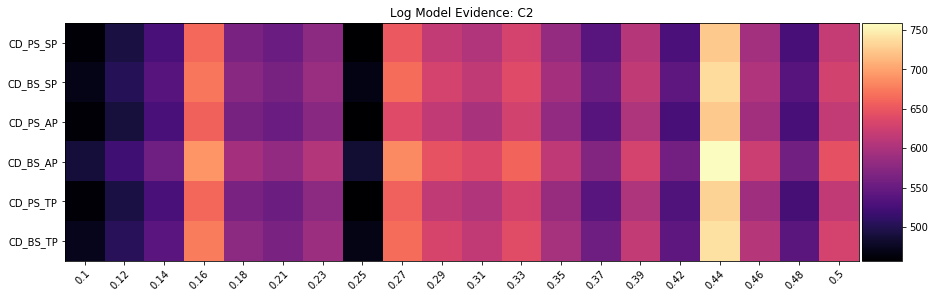

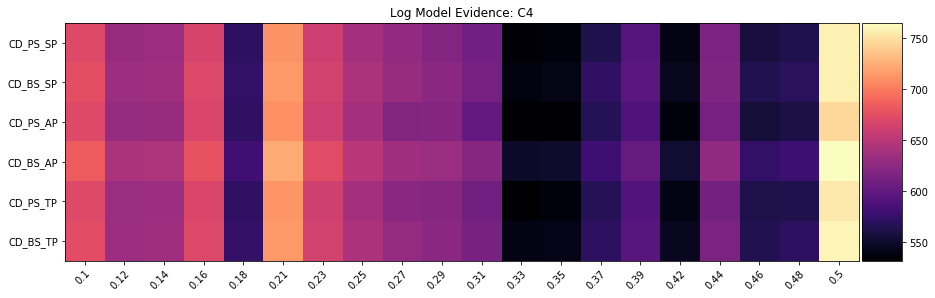

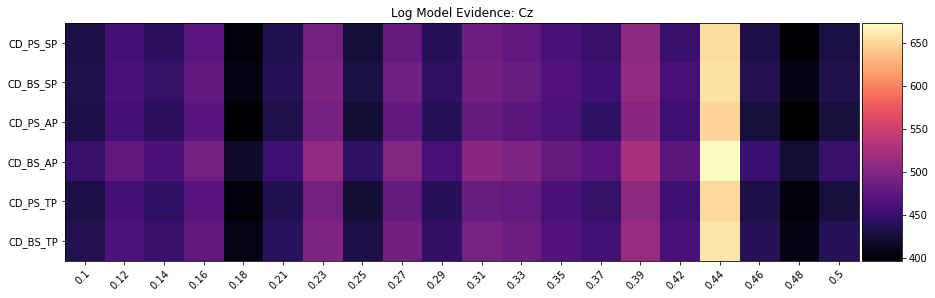

In [3]:
for elec_name in elec_names: 
    y_tw, results_all = process_tbt_logs(results_dir, num_blocks, regressor_names,
                                         elec_name, log_fnames)

    y_labels = []
    heat_data = np.empty((0, np.shape(y_tw)[0]))

    for key, values in results_all.items():
        y_labels.append(key)
        heat_data = np.vstack((heat_data, values))
        
    heatmap_lme(heat_data, y_tw, y_labels, title="Log Model Evidence: {}".format(elec_name))